In [126]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="ticks", color_codes=True)
%matplotlib inline

## Import the labelled dataset ##

In [127]:
df = pd.read_csv('data/from-azure/AllData-labelled.csv')

In [128]:
features_cols = ['GridSize', 'NumOfObstacles',
            'AvgDistanceToGoal', 'MaxDistanceToGoal', 'MinDistanceToGoal', 'AvgStartDistances', 'AvgGoalDistances',
            'NumOfAgents', 'ObstacleDensity', 'PointsAtSPRatio', 'Sparsity']
# features_cols = [ 'NumOfAgents', 'ObstacleDensity', 'PointsAtSPRatio', 'NumOfObstacles']


## Replace every row with runtime greater then 300000 (5 minutes) to be 300000 - removing computation errors (somehow it kept running more than 5 minutes) ##

In [129]:
runtime_cols = list(df.filter(like="Runtime"))
for runtime_col in runtime_cols:
    df[runtime_col] = df[runtime_col].where(df[runtime_col] < 300000, 300000)


In [130]:
runtime_cols = list(df.filter(like="Runtime"))

runtime_cols

['A*+OD+ID Runtime',
 'MA-CBS-Global-10/(EPEA*/SIC) choosing the first conflict in CBS nodes Runtime',
 'Basic-CBS/(A*/SIC)+ID Runtime',
 'ICTS 3E +ID Runtime',
 'EPEA*+ID Runtime',
 'Y Runtime']

In [131]:
count_df = df['Y'].value_counts().reset_index()
count_df['BestPercentage'] = count_df.apply(lambda row: row['Y']/len(df), axis=1)
count_df

index     Y  BestPercentage
0  MA-CBS-Global-10/(EPEA*/SIC) choosing the firs...  3306        0.553028
1                                ICTS 3E +ID Runtime   997        0.166778
2                                   EPEA*+ID Runtime   760        0.127133
3                      Basic-CBS/(A*/SIC)+ID Runtime   631        0.105554
4                                   A*+OD+ID Runtime   284        0.047508

In [132]:
count_df = df[df['Y Runtime'] < 300000]['Y'].value_counts().reset_index()
count_df['BestPercentage'] = count_df.apply(lambda row: row['Y']/len(df), axis=1)
count_df

index     Y  BestPercentage
0  MA-CBS-Global-10/(EPEA*/SIC) choosing the firs...  3164        0.529274
1                                ICTS 3E +ID Runtime   898        0.150217
2                                   EPEA*+ID Runtime   652        0.109067
3                      Basic-CBS/(A*/SIC)+ID Runtime   490        0.081967
4                                   A*+OD+ID Runtime   279        0.046671

In [133]:
print("Choosing the best alogirthm each time accuracy:", df['Y'].value_counts()[0] / len(df))

Choosing the best alogirthm each time accuracy: 0.5530277684844429


## Use pandas-profiling for some basic exploration. TAKES TIMES TO RUN ##

In [134]:
import pandas_profiling

pandas_profiling.ProfileReport(df[features_cols + runtime_cols + ["Y"]])


c:\users\omri\appdata\local\programs\python\python36\lib\site-packages\pandas\core\frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


## We then saw that AvgStartDistances, MaxDistanceToGoal and NumOfObstacles can be rejected! ##

In [135]:
# features_cols.remove("AvgStartDistances")
# features_cols.remove("MaxDistanceToGoal")
# features_cols.remove("NumOfObstacles")


## XGBoost training

In [145]:
import xgboost as xgb

from sklearn.model_selection import train_test_split

labels= ['A*+OD+ID Runtime',
        'MA-CBS-Global-10/(EPEA*/SIC) choosing the first conflict in CBS nodes Runtime',
        'EPEA*+ID Runtime',
        'Basic-CBS/(A*/SIC)+ID Runtime',
        'A*+OD+ID Runtime']

X_train, X_test, y_train, y_test = train_test_split(df, df['Y'], test_size=0.3)

xg_cls = xgb.XGBClassifier(n_estimators=100, max_depth=3, learning_rate=0.1, subsample=0.8, gamma=1, colsample_bytree=1)

xg_cls.fit(X_train[features_cols],y_train)

preds = xg_cls.predict(X_test[features_cols])

In [146]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test, preds)

0.6059085841694537

## Basic interpretation of the feature importance ##

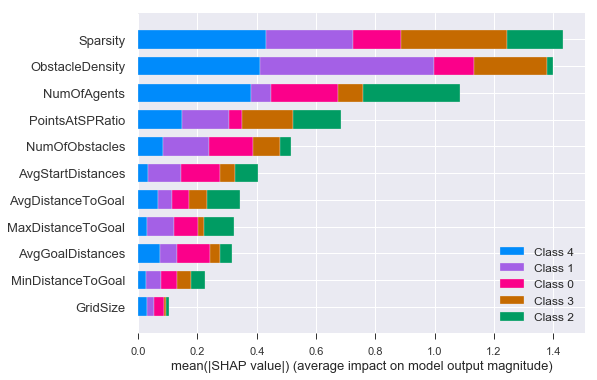

In [147]:
import shap

# load JS visualization code to notebook
shap.initjs()

explainer = shap.TreeExplainer(xg_cls)
shap_values = explainer.shap_values(X_train[features_cols])

# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
shap.summary_plot(shap_values, X_train[features_cols], plot_type="bar")

## Adding 'P Success' column to indicate if the predicted algorithm finished before 5 minutes

In [148]:
def runtime_to_success(col):
    splitted = col.split()
    splitted[-1] = "Success"
    return " ".join(splitted)

runtime_to_success("Y Runtime")

'Y Success'

In [149]:
X_test['P'] = xg_cls.predict(X_test[features_cols])
df['P'] = xg_cls.predict(df[features_cols])

In [150]:
X_test['P Success'] = X_test.apply(lambda x:x[runtime_to_success(x['P'])], axis=1)
df['P Success'] = df.apply(lambda x:x[runtime_to_success(x['P'])], axis=1)

In [151]:
X_test['P Runtime'] = X_test.apply(lambda x:x[x['P']], axis=1)
df['P Runtime'] = df.apply(lambda x:x[x['P']], axis=1)

runtime_cols.append('P Runtime')

In [152]:
runtime_per_algo = {}
for runtime in runtime_cols:
    substr_index = runtime.rfind(')')
    if(substr_index!=-1):
        key = runtime[:substr_index+1]
    else:
        key = runtime
    print(runtime)
    runtime_per_algo[key] = X_test[runtime].sum() 

A*+OD+ID Runtime
MA-CBS-Global-10/(EPEA*/SIC) choosing the first conflict in CBS nodes Runtime
Basic-CBS/(A*/SIC)+ID Runtime
ICTS 3E +ID Runtime
EPEA*+ID Runtime
Y Runtime
P Runtime


In [153]:
runtime_per_algo

{'A*+OD+ID Runtime': 91926183.71010038,
 'MA-CBS-Global-10/(EPEA*/SIC)': 182442506.72580034,
 'Basic-CBS/(A*/SIC)': 129351379.86570035,
 'ICTS 3E +ID Runtime': 73481000.33559991,
 'EPEA*+ID Runtime': 80057499.71899989,
 'Y Runtime': 58631416.57340043,
 'P Runtime': 118443973.93380032}

<BarContainer object of 7 artists>

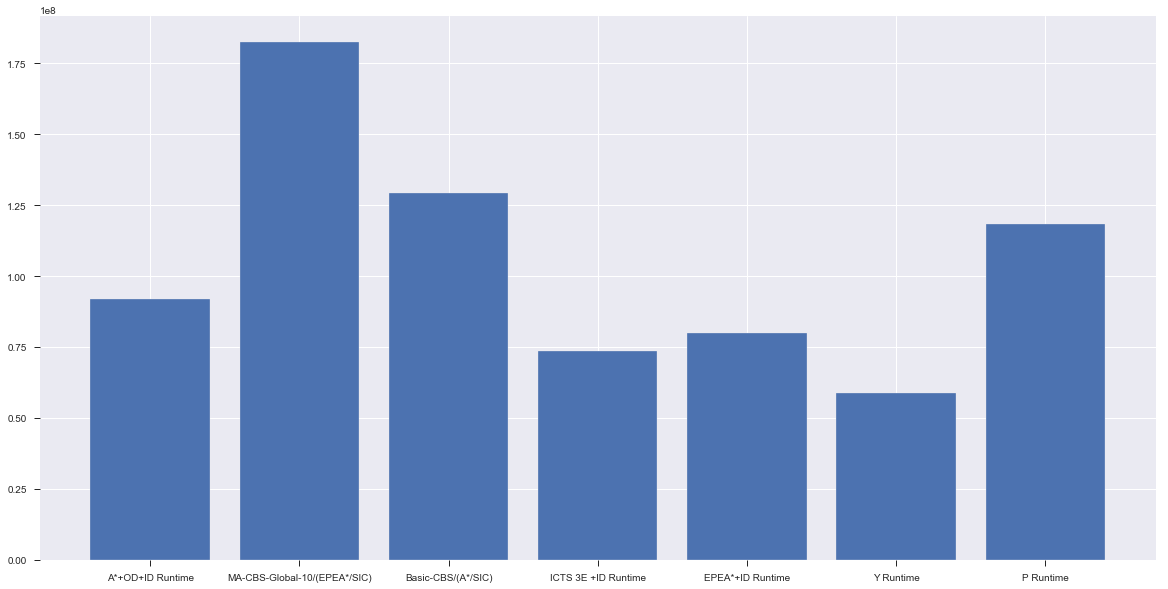

In [154]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.bar(*zip(*runtime_per_algo.items()))

## Let's visualize the success rate of our predicted alogrithm according to the oracle  ##
### NOTE: THIS GRAPH USED WITH TRAIN DATA ALSO ###

A*+OD+ID Success
MA-CBS-Global-10/(EPEA*/SIC) choosing the first conflict in CBS nodes Success
Basic-CBS/(A*/SIC)+ID Success
ICTS 3E +ID Success
EPEA*+ID Success
Y Success
P Success


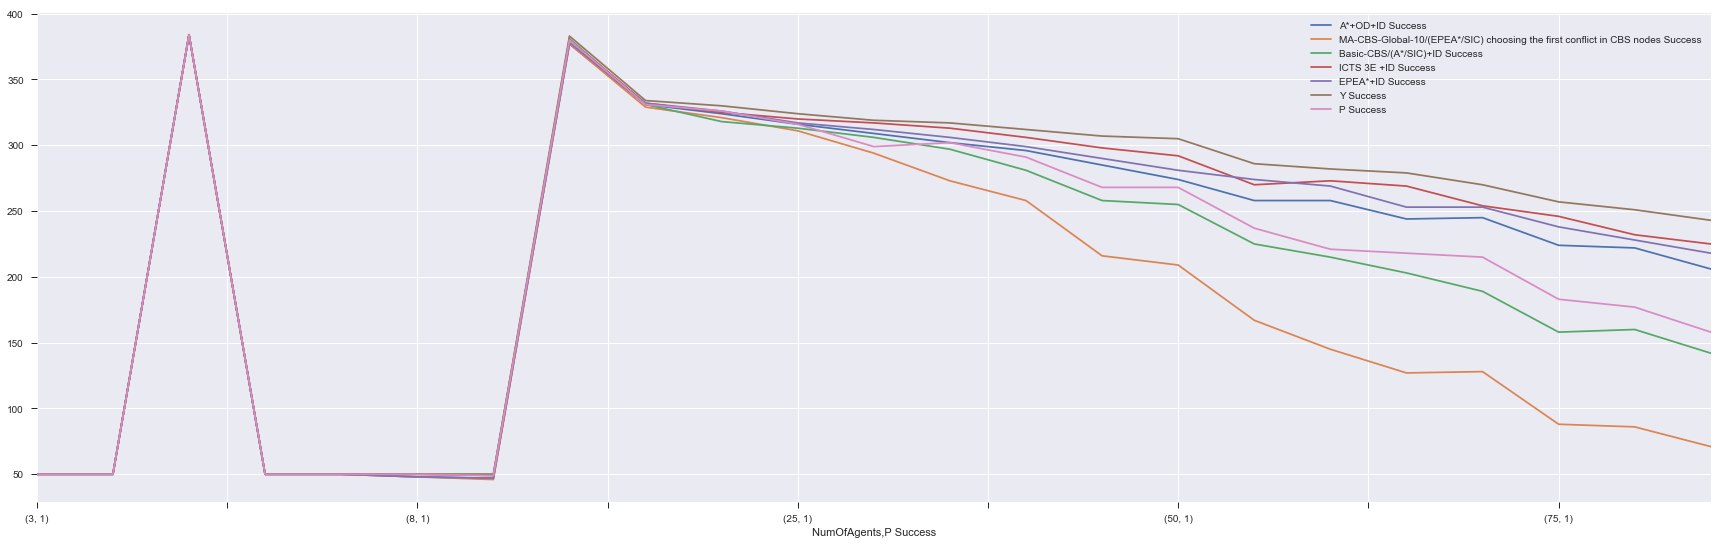

In [156]:
ax = plt.gca()
plt.rcParams["figure.figsize"] = (30,9)

for runtime_col in runtime_cols:
    print(runtime_to_success(runtime_col))
    s = df.groupby("NumOfAgents")[runtime_to_success(runtime_col)].value_counts()
    s.to_frame()[s.index.to_frame()[runtime_to_success(runtime_col)] == 1][runtime_to_success(runtime_col)].plot(ax=ax)
    
ax.legend()
    

## Let's visualize the success rate of our predicted alogrithm according to the oracle  ##

A*+OD+ID Success
MA-CBS-Global-10/(EPEA*/SIC) choosing the first conflict in CBS nodes Success
Basic-CBS/(A*/SIC)+ID Success
ICTS 3E +ID Success
EPEA*+ID Success
Y Success
P Success


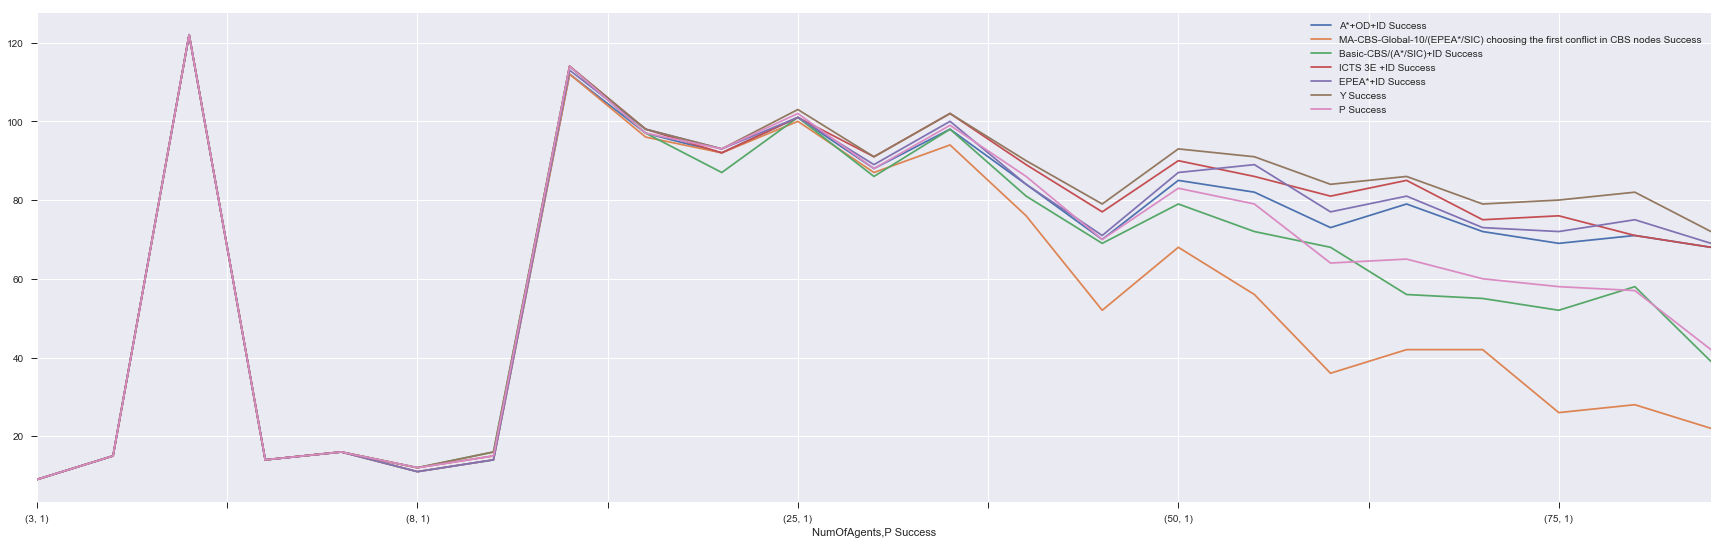

In [157]:
ax = plt.gca()
plt.rcParams["figure.figsize"] = (30,9)

for runtime_col in runtime_cols:
    print(runtime_to_success(runtime_col))
    s = X_test.groupby("NumOfAgents")[runtime_to_success(runtime_col)].value_counts()
    s.to_frame()[s.index.to_frame()[runtime_to_success(runtime_col)] == 1][runtime_to_success(runtime_col)].plot(ax=ax)
    
ax.legend()


## FROM HERE ONLY RANDOM TESTS ##

In [244]:
runtime_cols

['A*+OD+ID Runtime',
 'MA-CBS-Global-10/(A*+OD/SIC) choosing the first conflict in CBS nodes Runtime',
 'MA-CBS-Local-10/(single:A*/SIC multi:A*+OD/SIC) choosing the first conflict in CBS nodes Runtime',
 'Basic-CBS/(A*+OD/SIC) choosing the first conflict in CBS nodes Runtime',
 'MA-CBS-Global-10/(EPEA*/SIC) choosing the first conflict in CBS nodes Runtime',
 'MA-CBS-Local-10/(single:A*/SIC multi:EPEA*/SIC) choosing the first conflict in CBS nodes Runtime',
 'Basic-CBS/(A*/SIC) choosing cardinal conflicts using lookahead Runtime',
 'Basic-CBS/(A*/SIC)+ID Runtime',
 'Y Runtime',
 'P Runtime']

[ 29.7495    82.502815  32.871784 100.        21.343098  23.839773
  21.230524  23.081902  24.000988  36.664284  93.174286]
['MaxDistanceToGoal' 'ObstacleDensity' 'MinDistanceToGoal'
 'AvgDistanceToGoal' 'AvgStartDistances' 'GridRows' 'NumOfAgents'
 'AvgGoalDistances' 'GridColumns' 'PointsAtSPRatio' 'NumOfObstacles']
[ 6  4  7  5  8  0  2  9  1 10  3]


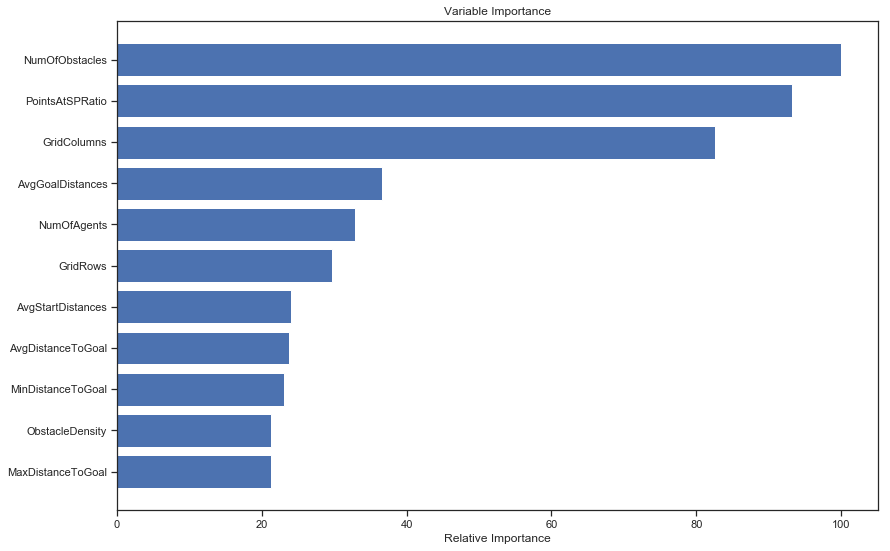

In [33]:
import numpy as np

features_cols = ['GridRows', 'GridColumns', 'NumOfAgents', 'NumOfObstacles', 'ObstacleDensity',
            'AvgDistanceToGoal', 'MaxDistanceToGoal', 'MinDistanceToGoal', 'AvgStartDistances', 'AvgGoalDistances',
            'PointsAtSPRatio']

feature_importance = xg_cls.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
print(feature_importance)
sorted_idx = np.argsort(feature_importance)
print(np.array(features_cols)[sorted_idx])
print(sorted_idx)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, np.array(features_cols)[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

Text(0, 0.5, '')

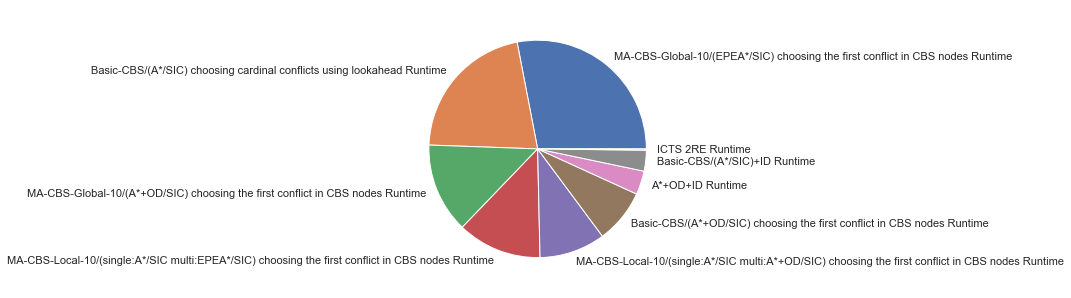

In [287]:
ax = plt.gca()
plt.rcParams["figure.figsize"] = (8,5)

pie_plt = df['Y'].value_counts().plot(kind='pie', legend=False, ax=ax)
pie_plt.set_ylabel('') #Removing column label from the plot

In [56]:
den_df['Y'].value_counts()

A*+OD+ID Runtime                                                                                    9
Basic-CBS/(A*/SIC)+ID Runtime                                                                       7
MA-CBS-Global-10/(EPEA*/SIC) choosing the first conflict in CBS nodes Runtime                       5
MA-CBS-Local-10/(single:A*/SIC multi:A*+OD/SIC) choosing the first conflict in CBS nodes Runtime    3
Basic-CBS/(A*/SIC) choosing cardinal conflicts using lookahead Runtime                              3
MA-CBS-Local-10/(single:A*/SIC multi:EPEA*/SIC) choosing the first conflict in CBS nodes Runtime    2
Name: Y, dtype: int64

In [40]:
pd.Series(y_pred).value_counts().plot(kind='pie')

NameError: name 'y_pred' is not defined

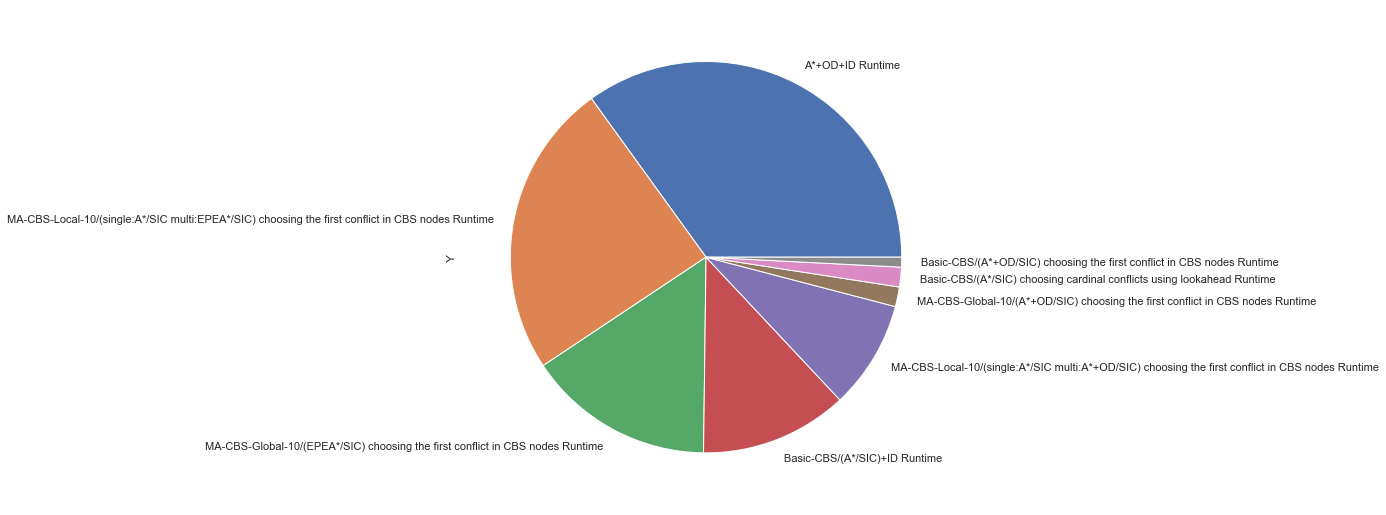

In [342]:
pd.Series(y_test).value_counts().plot(kind='pie')

In [122]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

                                                                                                  precision    recall  f1-score   support

                                                                                A*+OD+ID Runtime       0.64      0.41      0.50        22
                          Basic-CBS/(A*+OD/SIC) choosing the first conflict in CBS nodes Runtime       0.09      0.08      0.09        62
                          Basic-CBS/(A*/SIC) choosing cardinal conflicts using lookahead Runtime       0.27      0.24      0.25       151
                                                                   Basic-CBS/(A*/SIC)+ID Runtime       0.57      0.40      0.47        20
                                                                                ICTS 2RE Runtime       0.00      0.00      0.00         1
                   MA-CBS-Global-10/(A*+OD/SIC) choosing the first conflict in CBS nodes Runtime       0.12      0.10      0.11        86
                   MA-CBS-Global-

c:\users\omri\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


c:\users\omri\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


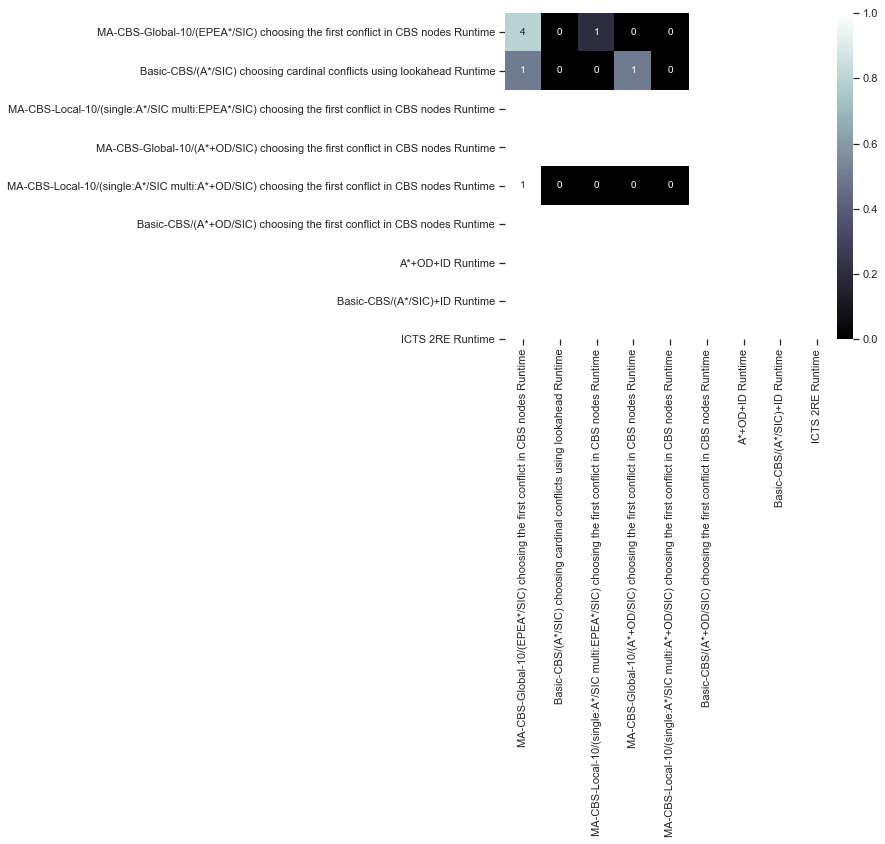

In [40]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes, normalized=True, cmap='bone'):
    plt.figure(figsize=[7, 6])
    norm_cm = cm
    if normalized:
        norm_cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        sns.heatmap(norm_cm, annot=cm, fmt='g', xticklabels=classes, yticklabels=classes, cmap=cmap)
        plt.savefig('confusion-matrix.png')

plot_confusion_matrix(cm, ['MA-CBS-Global-10/(EPEA*/SIC) choosing the first conflict in CBS nodes Runtime',
            'Basic-CBS/(A*/SIC) choosing cardinal conflicts using lookahead Runtime',
             'MA-CBS-Local-10/(single:A*/SIC multi:EPEA*/SIC) choosing the first conflict in CBS nodes Runtime',
           'MA-CBS-Global-10/(A*+OD/SIC) choosing the first conflict in CBS nodes Runtime',
           'MA-CBS-Local-10/(single:A*/SIC multi:A*+OD/SIC) choosing the first conflict in CBS nodes Runtime',
           'Basic-CBS/(A*+OD/SIC) choosing the first conflict in CBS nodes Runtime',
           'A*+OD+ID Runtime',
           'Basic-CBS/(A*/SIC)+ID Runtime',
           'ICTS 2RE Runtime'])

In [81]:
max_depths = np.linspace(1, 32, 32, endpoint=True)
train_results = []
test_results = []
for max_depth in max_depths:
    model = GradientBoostingClassifier(max_depth=max_depth)
    model.fit(X_train, y_train)
    train_pred = model.predict(X_train)
    acc_train = accuracy_score(y_train, train_pred)
    train_results.append(acc_train)
    y_pred = model.predict(X_test)
    acc_test = accuracy_score(y_test, y_pred)
    test_results.append(acc_test)
    
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(max_depths, train_results, 'b', label='Train accuracy')
line2, = plt.plot(max_depths, test_results, 'r', label='Test accuracy')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('accuracy')
plt.xlabel('Tree depth')
plt.title('GBM Accuracy according to maximum depth of each tree ')
plt.show()

ValueError: could not convert string to float: 'Unknown'

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]


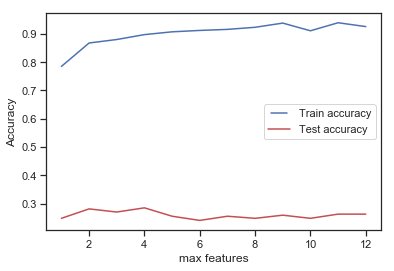

In [182]:
max_features = list(range(1, len(features_cols)+1))
print(max_features)
train_results = []
test_results = []
for max_feature in max_features:
    model = GradientBoostingClassifier(max_features=max_feature)
    model.fit(X_train, y_train)
    train_pred = model.predict(X_train)
    acc_train = accuracy_score(y_train, train_pred)
    train_results.append(acc_train)
    y_pred = model.predict(X_test)
    acc_test = accuracy_score(y_test, y_pred)
    test_results.append(acc_test)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(max_features, train_results, 'b', label='Train accuracy')
line2, = plt.plot(max_features, test_results, 'r', label='Test accuracy')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('Accuracy')
plt.xlabel('max features')
plt.show()

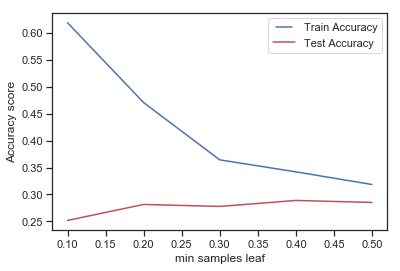

In [191]:
min_samples_leafs = np.linspace(0.1, 0.5, 5, endpoint=True)
train_results = []
test_results = []
for min_samples_leaf in min_samples_leafs:
    model = GradientBoostingClassifier(min_samples_leaf=min_samples_leaf)
    model.fit(X_train, y_train)
    train_pred = model.predict(X_train)
    acc_train = accuracy_score(y_train, train_pred)
    train_results.append(acc_train)
    y_pred = model.predict(X_test)
    acc_test = accuracy_score(y_test, y_pred)
    test_results.append(acc_test)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(min_samples_leafs, train_results, 'b', label='Train Accuracy')
line2, = plt.plot(min_samples_leafs, test_results, 'r', label='Test Accuracy')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('Accuracy score')
plt.xlabel('min samples leaf')
plt.show()

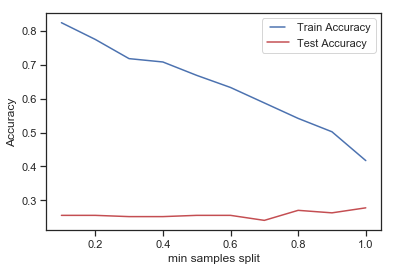

In [189]:
min_samples_splits = np.linspace(0.1, 1.0, 10, endpoint=True)
train_results = []
test_results = []
for min_samples_split in min_samples_splits:
    model = GradientBoostingClassifier(min_samples_split=min_samples_split)
    model.fit(X_train, y_train)
    train_pred = model.predict(X_train)
    acc_train = accuracy_score(y_train, train_pred)
    train_results.append(acc_train)
    y_pred = model.predict(X_test)
    acc_test = accuracy_score(y_test, y_pred)
    test_results.append(acc_test)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(min_samples_splits, train_results, 'b', label='Train Accuracy')
line2, = plt.plot(min_samples_splits, test_results, 'r', label='Test Accuracy')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('Accuracy')
plt.xlabel('min samples split')
plt.show()

In [46]:
from sklearn.metrics import classification_report

print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.25      0.59      0.36        66
           1       0.25      0.19      0.22        67
           2       0.23      0.07      0.11        44
           3       0.27      0.18      0.21        34
           4       0.14      0.12      0.13        24
           5       0.00      0.00      0.00        18
           6       0.00      0.00      0.00         9
           7       0.00      0.00      0.00         6
           8       0.00      0.00      0.00         2

   micro avg       0.24      0.24      0.24       270
   macro avg       0.13      0.13      0.11       270
weighted avg       0.21      0.24      0.20       270



c:\users\omri\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
